### This file trains a general three-layer ReLU network.
The trained network is investigated by the difference of two convex functions.

In [1]:
# Classification, Intrinsic dimension, Degeneracy
%run swiss_SetUp.ipynb

## Configuration
Title = "SWISS" # general two layer
device = "cuda:0"
pt_option=True
width = 30
dataset = "Swiss"
d = 2
n = 1000 # used number of data
num_class = 9

# create directory
output_path = f"./Results/{Title}"
create_directory(output_path)

In [2]:
# construct the dataset
from sklearn.datasets import make_swiss_roll
DATA = make_swiss_roll(n_samples=int(n/2), noise=0.4)[0]

trn_X = torch.tensor(DATA)[:,0].to(device)
trn_X = torch.stack((trn_X, torch.tensor(DATA)[:,2].to(device)), dim=1)
trn_X = torch.cat((trn_X, -trn_X), dim=0).float()
trn_Y = torch.ones(int(n/2)).to(device)
trn_Y = torch.cat((trn_Y, 0*trn_Y), dim=0).float().view(-1,1)
test_X = trn_X
test_Y = trn_Y
trn_X = trn_X * 0.1
data = trn_X
id = int(n/2)

In [3]:
# Network setting # d -> d1 -> 1
class polytope(nn.Module):
    def __init__(self, width, output_class=1, positive_init=True):
        super(polytope, self).__init__()
        self.fc0 = nn.Linear(d, width)
        self.fc1 = nn.Linear(width, output_class, bias=False)
        self.width = width # width
        self.bias = 1 - positive_init * 2
        if positive_init:
            # initialization, to all v_k to be positive.
            self.fc1.weight = nn.Parameter((self.W(0).norm(dim=1)**2 + self.b(0)**2).view(1,-1)+1)
        else:
               # initialization, to all v_k to be negative.
            self.fc1.weight = nn.Parameter(-(self.W(0).norm(dim=1)**2 + self.b(0)**2).view(1,-1)-1)
        
    def forward(self, x):
        self.g1 = self.fc0(x)
        self.h1 = F.relu(self.g1)
        self.g2 = self.fc1(self.h1)
        return self.g2 + self.bias
    
    def W(self, i):
        if i ==0:
            output = self.fc0.weight
        elif i ==1:
            output = self.fc1.weight
        return output
    def b(self, i):
        if i ==0:
            output = self.fc0.bias
        elif i ==1:
            output = self.fc1.bias
        return output
    
    def activation_pattern(self, x):
        self.forward(x)
        return (self.h1>0).float()
    
    def change_layer_weights(self, i, W, b):
        if W.shape == self.W(i).shape and b.shape == self.b(i).shape:
            if i ==0:
                self.fc0.weight = nn.Parameter(W)
                self.fc0.bias = nn.Parameter(b)
            elif i ==1:
                self.fc1.weight = nn.Parameter(W)
                self.fc1.bias = nn.Parameter(b)
        else:
            raise ValueError("wrong shape of input tensors")
    
    def partition(self, th=0.001, w=1.6, id=500, title="img", color='blue'):
        N = 200
        x,y = torch.meshgrid(torch.linspace(-w,w,N), torch.linspace(-w,w,N))
        grid = torch.stack((x,y),dim=2).to(device).float() # SHAPE 10,10,2
        rank = (self.forward(grid.view(-1,2))<th).float().view(N,N)                     # decision boundary, output<0
        plt.contourf(x,y,rank.cpu(), np.arange(-1,2,1), cmap='gray')
        #     plt.contourf(x,y,rank.cpu(), np.arange(-1,2,0.1), cmap='RdBu_r')
        plt.colorbar()
        for i in range(self.width):
            plt.contour(x,y, self.activation_pattern(grid.view(-1,2)).float().cpu().view(N,N,-1)[:,:,i], levels=1, colors=color, linewidths=0.5)

        blue_patch = mpatches.Patch(color='blue', label='1st layer')
        plt.legend(handles=[blue_patch])
        # dataset
        plt.scatter(trn_X[:id,0].cpu(),trn_X[:id,1].cpu(), marker='.')
        plt.scatter(trn_X[id:,0].cpu(),trn_X[id:,1].cpu(), marker='.')
        plt.title("Activation and decision boundary")
        # save the figure
        plt.savefig(f'./figs/{title}.png')
#         plt.show()
        plt.close()

In [4]:
class cover(nn.Module):
    def __init__(self, width, output_class=1, positive_init=True):
        super(cover, self).__init__()
        self.polytope_net1 = polytope(width=width, positive_init=positive_init)
        self.polytope_net2 = polytope(width=width, positive_init=positive_init)
        self.polytope_net3 = polytope(width=width, positive_init=positive_init)
        self.polytope_net4 = polytope(width=width, positive_init=positive_init)
        self.width=width
        self.width1= width
        self.width2= width
        self.width3= width
        self.width4= width
        
    def forward(self, x):
        self.a1 = self.polytope_net1(x)
        self.a2 = self.polytope_net2(x)

        output = -0.001+F.relu(self.a1) - F.relu(self.a2) 
        return output
    
    def partition(self, w=1.6, partition=False):
        N = 200
        x,y = torch.meshgrid(torch.linspace(-w,w,N), torch.linspace(-w,w,N))
        grid = torch.stack((x,y),dim=2).to(device).float() # SHAPE 10,10,2
        rank = (net(grid.view(-1,2))<0).float().view(N,N)                     # decision boundary, output<0
        plt.contourf(x,y,rank.cpu(), np.arange(-1,2,1), cmap='gray')
        #     plt.contourf(x,y,rank.cpu(), np.arange(-1,2,0.1), cmap='RdBu_r')
        plt.colorbar()
        if partition:
            for i in range(self.width1):
                plt.contour(x,y, self.polytope_net1.activation_pattern(grid.view(-1,2)).float().cpu().view(N,N,-1)[:,:,i], levels=1, colors='blue', linewidths=0.5)
            for i in range(self.width2):
                plt.contour(x,y, self.polytope_net2.activation_pattern(grid.view(-1,2)).float().cpu().view(N,N,-1)[:,:,i], levels=1, colors='red', linewidths=0.5)
#             for i in range(self.width3):
#                 plt.contour(x,y, self.polytope_net3.activation_pattern(grid.view(-1,2)).float().cpu().view(N,N,-1)[:,:,i], levels=1, colors='green', linewidths=0.5)
#             for i in range(self.width4):
#                 plt.contour(x,y, self.polytope_net4.activation_pattern(grid.view(-1,2)).float().cpu().view(N,N,-1)[:,:,i], levels=1, colors='pink', linewidths=0.5)

        black_patch = mpatches.Patch(color='black', label='Rank 0')
        gray_patch = mpatches.Patch(color='gray', label='Rank 1')
        blue_patch = mpatches.Patch(color='blue', label='1st layer')
#         plt.legend(handles=[blue_patch])
        # dataset
        plt.scatter(trn_X[:int(n/2),0].cpu(),trn_X[:int(n/2),1].cpu(), marker='.')
        plt.scatter(trn_X[int(n/2):,0].cpu(),trn_X[int(n/2):,1].cpu(), marker='.')
        plt.title("Decision boundary")
        plt.savefig(f"./figs/{epoch+1}.png")
#         plt.show()
        plt.close()
net = cover(width=50).to(device)

# net.polytope_net1.change_layer_weights(i=1, W=.1*torch.randn_like(net.polytope_net1.W(1)), b=1*torch.ones_like(net.polytope_net1.b(1)))
# net.polytope_net2.change_layer_weights(i=1, W=.1*torch.randn_like(net.polytope_net2.W(1)), b=1*torch.ones_like(net.polytope_net2.b(1)))
epoch=-1
net.partition(partition=True)


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Start Training
Epoch:     1 || TRN_loss: 0.2448 || TEST_loss: 0.0000 || TRN_ACC: 99.200 || TEST_ACC: 0.000
Epoch:  1000 || TRN_loss: 0.2186 || TEST_loss: 0.0000 || TRN_ACC: 99.300 || TEST_ACC: 0.000
Epoch:  2000 || TRN_loss: 0.1955 || TEST_loss: 0.0000 || TRN_ACC: 99.400 || TEST_ACC: 0.000
Epoch:  3000 || TRN_loss: 0.1750 || TEST_loss: 0.0000 || TRN_ACC: 99.600 || TEST_ACC: 0.000


KeyboardInterrupt: 

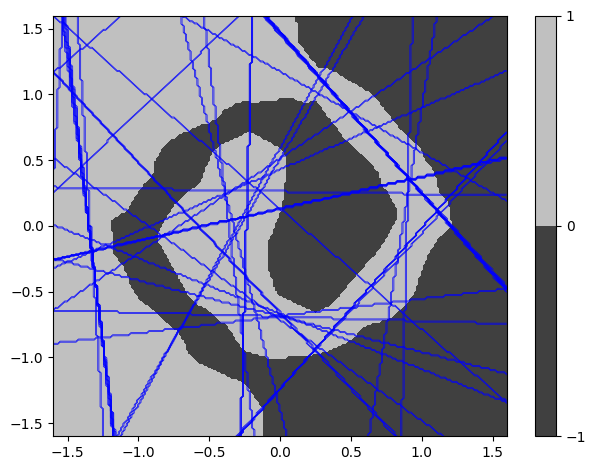

In [18]:
wd=1000
lr=0.0001
Epochs=100*1000
    
folder_name = output_path + '/runs/' + datetime.datetime.now().strftime("%B%d_%H_%M_%S")
writer = SummaryWriter(folder_name)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

grad_norm = 0
trn_loss_tr = np.empty(0)
test_loss_tr = np.empty(0)
trn_acc_tr = np.empty(0)
test_acc_tr = np.empty(0)


test_acc = 0
test_loss = torch.zeros(1)
print("Start Training")
time.sleep(1)

log_period = 1000
for epoch in range(Epochs) :
    loss = criterion(net(trn_X), trn_Y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    

    if epoch ==0 or epoch % 1000 == 999 : # perturb every 50000 steps
        trn_loss_tr = np.append(trn_loss_tr, loss.item())
        test_loss_tr = np.append(test_loss_tr, test_loss.item())

        trn_acc = ((net(trn_X)>0).float() == trn_Y).sum().item() / len(trn_Y) *100
        trn_acc_tr = np.append(trn_acc_tr, trn_acc)
        test_acc_tr = np.append(test_acc_tr, test_acc)
        writer.add_scalars("ReLU/Loss", {
            "Trn_Loss": loss.item(),
            "Test_Loss": test_loss.item(), }
                        , epoch+1)
        writer.add_scalars("ReLU/Accuracy", {
            "Trn_acc": trn_acc,
            "Test_acc": test_acc, }
                        , epoch+1)
        if pt_option :
            print(f"Epoch: {epoch+1 :>5} || TRN_loss: {loss.item() :.4f} || TEST_loss: {test_loss.item():.4f} || TRN_ACC: {trn_acc:.3f} || TEST_ACC: {test_acc:.3f}")
            net.partition(partition=True)
            net.polytope_net1.partition(title=f"net1_{epoch+1}", th=net.polytope_net1(trn_X).mean())
            net.polytope_net2.partition(title=f"net2_{epoch+1}", th=net.polytope_net2(trn_X).mean(), color='red')
print("saving the net ... ")
torch.save(net.state_dict(), f"saved_net_width_{wd}_{int(trn_acc)}.pt") 
time.sleep(1)
print("Finish Training")

Save the final result images

In [ ]:
epoch=-3
net.partition(partition=True)
epoch=-4
net.partition(partition=False)

Below, make a gif file :: images to video (mp4)

In [19]:
import cv2
import glob

folder_name = "./figs"
img_array = []
for filename in sorted(glob.glob(f'{folder_name}/*.png'), key=os.path.getmtime):
# for filename in (glob.glob(f'{folder_name}/*.png')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width, height)
    img_array.append(img)
 
 
out = cv2.VideoWriter(f'{folder_name}/video.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
print("Completed!")

Completed!
